## Introduction
In this exercise, you’ll learn how to improve training outcomes by including an early stopping callback to prevent overfitting.

When you're ready, run this next cell to set everything up!

First load the Spotify dataset. Your task will be to predict the popularity of a song based on various audio features, like 'tempo', 'danceability', and 'mode'

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import tensorrt

spotify = pd.read_csv('spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


This code is part of a machine learning pipeline that uses the Spotify dataset to predict track popularity. Here's a breakdown:

1) It imports necessary libraries. pandas is used for data manipulation, sklearn.preprocessing for data preprocessing, sklearn.compose to make a column transformer, sklearn.model_selection for splitting the dataset, and tensorflow for building and training a neural network.

2) It reads the Spotify dataset using pd.read_csv() and stores it in the spotify variable.

3) It creates a copy of the spotify DataFrame, drops any rows with missing values using dropna(), and assigns it to X. y is set as the 'track_popularity' column from X, which is the target variable we want to predict.

4) It stores the 'track_artist' column in the artists variable.

5) It defines numerical and categorical features in features_num and features_cat respectively.

6) It creates a preprocessor using make_column_transformer(). This preprocessor will standardize numerical features (subtract mean and divide by standard deviation) using StandardScaler() and convert categorical features into a one-hot encoded format using OneHotEncoder(). This is done to prepare the data for machine learning algorithms, which often require numerical input and can be sensitive to the scale of the input features.


7) The group_split function is then used to split X and y into training and validation sets (X_train, X_valid, y_train, y_valid), grouping by the artists.

8) The preprocessor (defined in your previous code) is fitted on the training data and used to transform both the training and validation data. This ensures that the data is correctly scaled and encoded for the model.

9) The target variables (y_train and y_valid) are divided by 100 to rescale them from 0-100 to 0-1. This is a common practice when dealing with percentages or proportions in machine learning.

10) The input_shape is determined from the number of columns in X_train (after preprocessing). This will be used as the input shape for the neural network model.

11) Finally, the input_shape is printed out.




Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the Spotify dataset.

Minimum Validation Loss: 0.1945


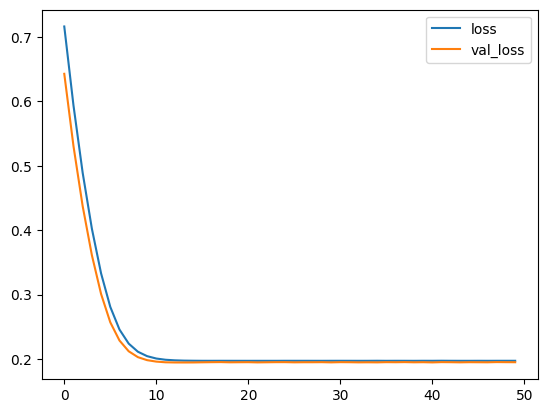

In [5]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1945


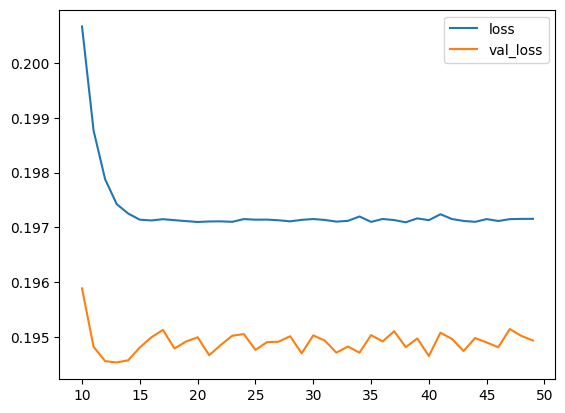

In [6]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

## 1) Evaluate Baseline
What do you think? Would you say this model is underfitting, overfitting, just right?
>The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each. Run the next cell to train the network and see the learning curves.

Epoch 1/50
49/49 [==============================] - 1s 4ms/step - loss: 0.2370 - val_loss: 0.2073
Epoch 2/50
49/49 [==============================] - 0s 2ms/step - loss: 0.2023 - val_loss: 0.2015
Epoch 3/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1970 - val_loss: 0.1989
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1941 - val_loss: 0.1985
Epoch 5/50
 1/49 [..............................] - ETA: 0s - loss: 0.1981

49/49 [==============================] - 0s 2ms/step - loss: 0.1925 - val_loss: 0.1967
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1902 - val_loss: 0.1963
Epoch 7/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1883 - val_loss: 0.1961
Epoch 8/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1876 - val_loss: 0.1959
Epoch 9/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1860 - val_loss: 0.1969
Epoch 10/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1854 - val_loss: 0.1952
Epoch 11/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1844 - val_loss: 0.1968
Epoch 12/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1839 - val_loss: 0.1975
Epoch 13/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1831 - val_loss: 0.1955
Epoch 14/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1821 - val_loss: 0.1956
Epoch 15/50
49/49 [=======

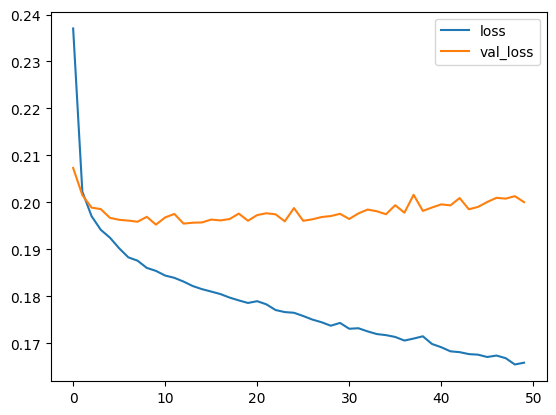

In [8]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

## 2) Add Capacity
What is your evaluation of these curves? Underfitting, overfitting, just right?
>Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping. (We'll see another in the next lesson!)

## 3) Define Early Stopping Callback
Now define an early stopping callback that waits 5 epochs (patience') for a change in validation loss of at least 0.001 (min_delta) and keeps the weights with the best loss (restore_best_weights).

In [10]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001,
    patience = 5,
    restore_best_weights = True,
)

Now run this cell to train the model and get the learning curves. Notice the callbacks argument in model.fit.

Epoch 1/50
49/49 [==============================] - 1s 4ms/step - loss: 0.2220 - val_loss: 0.2031
Epoch 2/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1999 - val_loss: 0.1988
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1954 - val_loss: 0.1948
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1932 - val_loss: 0.1945
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1901 - val_loss: 0.1932
Epoch 6/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1891 - val_loss: 0.1936
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1873 - val_loss: 0.1953
Epoch 8/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1872 - val_loss: 0.1956
Epoch 9/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1855 - val_loss: 0.1933
Epoch 10/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1846 - val_loss: 0.1942
Minimum Validation 

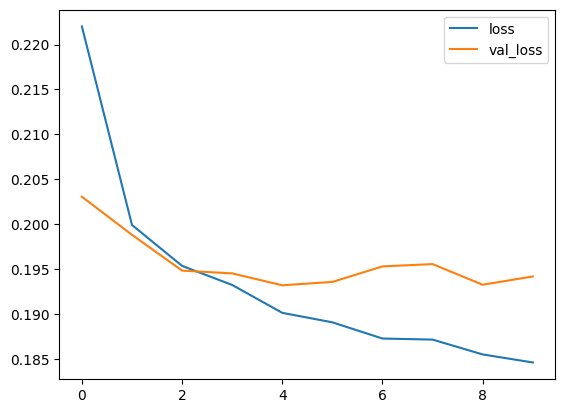

In [11]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

## 4) Train and Interpret
Was this an improvement compared to training without early stopping?

he early stopping callback did stop the training once the network began overfitting. Moreover, by including restore_best_weights we still get to keep the model where validation loss was lowest.

If you like, try experimenting with patience and min_delta to see what difference it might make.